In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
from skimage.metrics import structural_similarity as ssim
import os
import copy
import cv2
from IPython.display import Image 
from google.colab.patches import cv2_imshow
from torch.optim import lr_scheduler
from torch.utils.data.dataset import Dataset
from skimage import io, transform
from PIL import Image, ImageOps
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101


In [3]:
#this data loading code runs for samarth

train_image_path = './drive/My Drive/AML_assignments/Train_images/Images/'
train_mask_path = './drive/My Drive/AML_assignments/Train_masks/Contours_black/'
validation_image_path = './drive/My Drive/AML_assignments/Test_images/set1/'
validation_mask_path = './drive/My Drive/AML_assignments/Test_masks/Contours_black_test1set/'

# #this data loading code runs for varsha 
# train_image_path = './drive/My Drive/IITB_assignments/AML_assignments/Train_images/Images/'
# train_mask_path = './drive/My Drive/IITB_assignments/AML_assignments/Train_masks/Contours_grey/'
# validation_image_path = './drive/My Drive/IITB_assignments/AML_assignments/Test_images/set1/'
# validation_mask_path = './drive/My Drive/IITB_assignments/AML_assignments/Test_masks/Contours_grey_test1set/'

batch_size = 16
num_epochs = 100

In [4]:
# Display image
imgfile = './drive/My Drive/AML_assignments/Train_images/Images/P01-0140.jpg'
Image.open(imgfile)
print(cv2.imread('./drive/My Drive/AML_assignments/Test_images/set1/P17-0080.jpg').shape)

(256, 216, 3)


In [ ]:
# Display mask
maskfile = './drive/My Drive/AML_assignments/Train_masks/Contours_grey/P01-0140.jpg'
Image.open(maskfile)
print(cv2.imread('./drive/My Drive/AML_assignments/Test_masks/Contours_grey_test1set/P17-0080.jpg').shape)

(256, 216, 3)


In [5]:
# Model definition

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))   

class UNet(nn.Module):
    def __init__(self):
        super().__init__()                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)        
        self.conv_last = nn.Conv2d(64,1, 1)
        self.sig_act = nn.Sigmoid()
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)        
        x = self.dconv_down4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)  
        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)         
        x = self.dconv_up1(x)
        out = self.conv_last(x)
        out = self.sig_act(out)
        return out

def unet(pretrained=False, progress=True, **kwargs):
    model = UNet(**kwargs)
    return model

In [6]:
# Initialize the model for this run
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = unet()

# send model to device-cuda
model_ft = model_ft.to(device)

# Print the model we just instantiated
print(model_ft)

#Summary of the model
from torchsummary import summary
y = (1,216,216) #works for (216,256) too
summary(model_ft, y)

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [7]:
class RV_Data_train(Dataset):
    def __init__(self, path, transforms=None):
        self.path = path
        self.list = os.listdir(self.path)   
        self.transforms = transforms
        
    def __getitem__(self, index):
        # stuff
        image_path = train_image_path
        mask_path = train_mask_path
        image = Image.open(image_path+self.list[index])
        mask = Image.open(mask_path+self.list[index])
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
            return (image, mask)

    def __len__(self):
        return len(self.list)

In [8]:
class RV_Data_valid(Dataset):
    def __init__(self, path, transforms=None):
        self.path = path
        self.list = os.listdir(self.path)   
        self.transforms = transforms
        
    def __getitem__(self, index):
        # stuff
        image_path = validation_image_path
        mask_path = validation_mask_path
        image = Image.open(image_path+self.list[index])
        mask = Image.open(mask_path+self.list[index])
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
            return (image, mask)

    def __len__(self):
        return len(self.list)

In [9]:
# train data generator
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}
transform = transforms.Compose([transforms.Resize((216,216)), transforms.Grayscale(), transforms.ToTensor()
                                   ]) 
training_set = RV_Data_train(train_image_path,transform)
training_generator = torch.utils.data.DataLoader(training_set, **params)

In [10]:
print('Length of train dataset is:', len(training_set))
print('Length of train dataloader is:', len(training_generator))

Length of train dataset is: 243
Length of train dataloader is: 16


In [11]:
#validation data generator

validation_set = RV_Data_valid(validation_image_path,transform)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

In [12]:
print('Length of validation dataset is:', len(validation_set))
print('Length of validation dataloader is:', len(validation_generator))

Length of validation dataset is: 262
Length of validation dataloader is: 17


In [13]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)     
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
 
        return (1 - dice_loss)

In [14]:
criterion = DiceLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr = 0.00005)

In [ ]:
# running_loss = 0.0
# running_loss1 = 0.0
# since = time.time()
# for epoch in range(num_epochs):
#     print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#     print('-' * 10)
   
#     # Training
#     for imgs, masks in training_generator:
        
#         # Transfer to GPU
#         imgs, masks = imgs.to(device), masks.to(device)
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model_ft(imgs)
#         loss = criterion(outputs, masks)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         epoch_loss = running_loss
#         print('{} Loss: {:.4f} ' .format('Train', epoch_loss))
        
#         running_loss = 0.0
        
#     time_elapsed1 = time.time() - since
#     print('Time taken for one epoch {:.0f}min {:.0f}s'.format(time_elapsed1 // 60, time_elapsed1 % 60))
#     torch.save(model_ft.state_dict(), '/content/drive/My Drive/AML_assignments/model_black.pt')
# print('Finished Training')

Epoch 0/99
----------
Train Loss: 0.8883 
Train Loss: 0.9141 
Train Loss: 0.8999 
Train Loss: 0.8905 
Train Loss: 0.8855 
Train Loss: 0.9147 
Train Loss: 0.8781 
Train Loss: 0.8897 
Train Loss: 0.8761 
Train Loss: 0.8993 
Train Loss: 0.8895 
Train Loss: 0.8599 
Train Loss: 0.8760 
Train Loss: 0.8950 
Train Loss: 0.8875 
Train Loss: 0.8962 
Time taken for one epoch 2min 49s
Epoch 1/99
----------
Train Loss: 0.8717 
Train Loss: 0.8766 
Train Loss: 0.8710 
Train Loss: 0.8552 
Train Loss: 0.8917 
Train Loss: 0.8988 
Train Loss: 0.8697 
Train Loss: 0.8827 
Train Loss: 0.8814 
Train Loss: 0.9009 
Train Loss: 0.9162 
Train Loss: 0.9214 
Train Loss: 0.8936 
Train Loss: 0.8910 
Train Loss: 0.9101 
Train Loss: 0.8696 
Time taken for one epoch 2min 60s
Epoch 2/99
----------
Train Loss: 0.8863 
Train Loss: 0.8837 
Train Loss: 0.8716 
Train Loss: 0.8682 
Train Loss: 0.8689 
Train Loss: 0.8973 
Train Loss: 0.8590 
Train Loss: 0.8697 
Train Loss: 0.8779 
Train Loss: 0.8356 
Train Loss: 0.8669 
Train 

Epoch 0/99
----------
Train Loss: 0.8872 
Validation Loss: 0.0509 
Time taken for one batch 3m 33s
Epoch 1/99
----------
Train Loss: 0.8621 
Validation Loss: 0.0478 
Time taken for one batch 3m 46s
Epoch 2/99
----------
Train Loss: 0.8132 
Validation Loss: 0.0425 
Time taken for one batch 3m 58s
Epoch 3/99
----------
Train Loss: 0.7194 
Validation Loss: 0.0346 
Time taken for one batch 4m 11s
Epoch 4/99
----------
Train Loss: 0.7063 
Validation Loss: 0.0414 
Time taken for one batch 4m 23s
Epoch 5/99
----------
Train Loss: 0.6804 
Validation Loss: 0.0369 
Time taken for one batch 4m 36s
Epoch 6/99
----------
Train Loss: 0.6367 
Validation Loss: 0.0375 
Time taken for one batch 4m 48s
Epoch 7/99
----------
Train Loss: 0.6406 
Validation Loss: 0.0310 
Time taken for one batch 5m 1s
Epoch 8/99
----------
Train Loss: 0.6249 
Validation Loss: 0.0424 
Time taken for one batch 5m 13s
Epoch 9/99
----------
Train Loss: 0.6251 
Validation Loss: 0.0398 
Time taken for one batch 5m 26s
Epoch 10/99

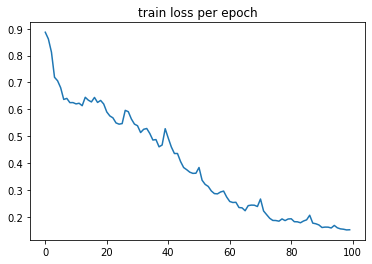

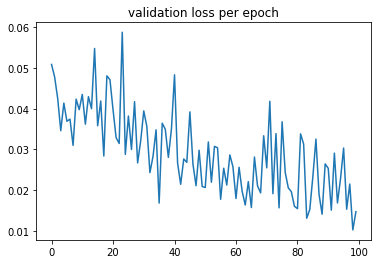

In [16]:
running_loss = 0.0
running_loss1 = 0.0
loss_train = []
loss_valid = []
since = time.time()
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
   
    # Training
    for imgs, masks in training_generator:
        
        # Transfer to GPU
        imgs, masks = imgs.to(device), masks.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_ft(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
   
    # print statistics
    epoch_loss = running_loss/len(training_generator)
    print('{} Loss: {:.4f} ' .format('Train', epoch_loss))
    loss_train.append(epoch_loss)

    running_loss = 0.0

    for imgs, masks in validation_generator:

        # Transfer to GPU
        imgs, masks = imgs.to(device), masks.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward  # backward and optimisation happen only in train phase!
        outputs = model_ft(imgs)
        loss = criterion(outputs, masks)
        running_loss1 += loss.item()
    
    # print statistics
    epoch_loss = running_loss1/ len(validation_generator)
    print('{} Loss: {:.4f} ' .format('Validation', epoch_loss))
    loss_valid.append(epoch_loss)

    running_loss1 = 0.0
        
    time_elapsed1 = time.time() - since
    print('Time taken for one batch {:.0f}m {:.0f}s'.format(time_elapsed1 // 60, time_elapsed1 % 60))
    torch.save(model_ft.state_dict(), '/content/drive/My Drive/AML_assignments/model_black_1.pt')
    
print('Finished Training')
plt.title("train loss per epoch") 
plt.plot(loss_train)
plt.figure()
plt.title("validation loss per epoch") 
plt.plot(loss_valid)

In [17]:
model = unet()
model.load_state_dict(torch.load('./drive/My Drive/AML_assignments/model_black_1.pt'))
model.eval()

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [54]:
img = Image.open('./drive/My Drive/AML_assignments/Test_images/set2/P34-0140.jpg')

In [31]:
# inp = cv2.imread('./drive/My Drive/AML_assignments/Train_images/Images/P01-0080.jpg')
# print(np.max(inp))
# print(inp.dtype)
# print(type(inp))
# print(inp.shape)

In [55]:
trans = transforms.Compose([transforms.Resize((216,216)), transforms.Grayscale(), transforms.ToTensor()
    ])

inp = trans(img)
print(inp.shape)
# input = input.to(device)

torch.Size([1, 216, 216])


In [56]:
c,h,w = inp.shape
image = inp.reshape(1,c,h,w)
# image = torch.squeeze_(0).view(1,c, h, w).float()
print(image.shape)

torch.Size([1, 1, 216, 216])


In [57]:
output = model(image)
print(output.shape)

torch.Size([1, 1, 216, 216])


In [22]:
output

tensor([[[[6.1470e-30, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 6.0525e-32]]]], grad_fn=<SigmoidBackward>)

In [58]:
om =output.squeeze().detach().cpu().numpy()
om = torch.tensor(om)
# op = om.permute(1,2,0)
print(om.shape)

torch.Size([216, 216])


255


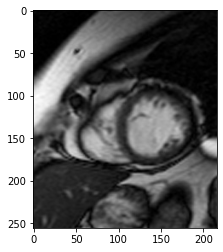

In [59]:
plt.imshow(img)
print(np.max(img))

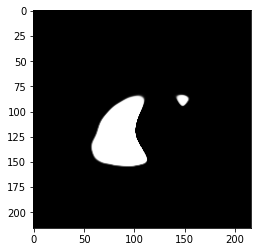

In [60]:
plt.imshow(om, cmap = 'gray')